In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

### Separar datos para el modelo 

In [2]:
df = pd.read_excel("Boletas electrónicas emitidas en estaciones de servicio.xlsx")
df[:-45].to_csv('train.csv')
df[-45:-15].to_csv('test.csv')
df[-15:].to_csv('demo.csv')

In [3]:
df.sort_values('total_boletas')

,periodo,total_boletas
452,2021-03-28,18.615376
451,2021-03-27,21.792249
261,2020-09-18,34.843129
262,2020-09-19,35.413580
459,2021-04-04,38.112180
...,...,...
834,2022-04-14,116.101220
31,2020-02-01,116.923878
729,2021-12-30,117.138653
58,2020-02-28,117.733634


### Generar tabla de feriados

In [4]:
import requests

response = []

for year in [2020,2021,2022]:
    url = f"https://date.nager.at/api/v2/publicholidays/{year}/CL"
    r = requests.request("GET", url).json()
    response += r

date = []
localname = []
index = []
for i in range(len(response)):
    response_i = response[i]
    date.append(response_i['date'])
    localname.append(response_i['localName'])
    index.append(i)
    
feriados_CL = pd.DataFrame({'date': dict(zip(index, date)),
                            'localName': dict(zip(index, localname))})

feriados_CL.to_csv('feriados_CL.csv')

feriados_CL.head(5)

,date,localName
0,2020-01-01,Año Nuevo
1,2020-04-10,Viernes Santo
2,2020-04-11,Sábado Santo
3,2020-05-01,Día del Trabajo
4,2020-05-21,Día de las Glorias Navales


### Funciones y ETL

In [257]:
name_dayofweek = {0: 'Lu', 1: 'Ma', 2: 'Mi', 3: 'Ju', 4: 'Vi', 5: 'Sa', 6: 'Do'}

def read_csv(path_csv = '', datetime = ''):
    data = pd.read_csv(path_csv, parse_dates = [datetime])
    if 'Unnamed: 0' in data.columns:
        del data['Unnamed: 0']
    return data  

def time_variables(data, datetime = ''):
    serie_dt = data[datetime]
    holiday = read_csv('feriados_CL.csv', 'date')['date']
    data['month'] = serie_dt.dt.month
    data['dayofweek'] = serie_dt.dt.dayofweek
    data['dayofmonth'] = serie_dt.dt.day
    data['is_holiday'] = np.where(data[datetime].isin(holiday),1,0)
    #data['isin_5days'] = np.where(data['dayofmonth'].isin([1,2,3,4,5]),1,0)
    #data['isin_28days'] = np.where(data['dayofmonth'].isin([28,29,30,31]),1,0)
    #data['is_fiestaspatrias'] = np.where(data['dayofmonth'].isin([18,19]) & data['month'].isin([9]),1,0)
    return data

def data_asfreq(data, y= 'total_boletas', datetime = 'periodo', freq = 'd'):
    data.set_index(datetime, inplace = True)
    data = data.asfreq(freq)
    data = data.sort_index()
    if y != None:
        data = data.rename(columns={y:'y'})
    return data

### EDA 

In [206]:
train = read_csv('train.csv', 'periodo')
train = time_variables(train, 'periodo')
train = data_asfreq(train, 'total_boletas', 'periodo', 'd')
train.head(5)

,y,month,dayofweek,dayofmonth,is_holiday
periodo,,,,,
2020-01-01,87.353347,1,2,1,1
2020-01-02,93.220609,1,3,2,0
2020-01-03,103.101330,1,4,3,0
2020-01-04,105.917988,1,5,4,0
2020-01-05,92.631512,1,6,5,0


In [207]:
train.isnull().sum()

y             0
month         0
dayofweek     0
dayofmonth    0
is_holiday    0
dtype: int64

In [208]:
test = read_csv('test.csv', 'periodo')
test = time_variables(test, 'periodo')
test = data_asfreq(test, 'total_boletas', 'periodo', 'd')
test.head(5)

,y,month,dayofweek,dayofmonth,is_holiday
periodo,,,,,
2022-06-01,107.864432,6,2,1,0
2022-06-02,103.138670,6,3,2,0
2022-06-03,104.716546,6,4,3,0
2022-06-04,97.958791,6,5,4,0
2022-06-05,89.490558,6,6,5,0


In [209]:
test.isnull().sum()

y             0
month         0
dayofweek     0
dayofmonth    0
is_holiday    0
dtype: int64

Fechas train : 2020-01-01 00:00:00 --- 2022-05-31 00:00:00  (n=882)
Fechas test  : 2022-06-01 00:00:00 --- 2022-06-30 00:00:00  (n=30)


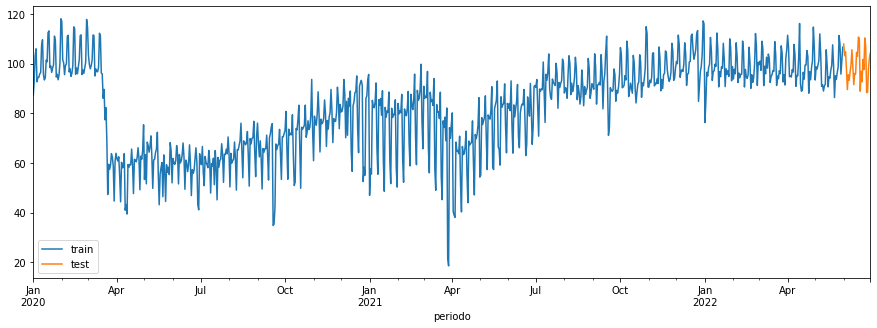

In [210]:
print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax = plt.subplots(figsize=(15, 5))
train['y'].plot(ax=ax, label='train')
test['y'].plot(ax=ax, label='test')
ax.legend();

### Model

In [211]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

In [212]:
train.columns[1:]

Index(['month', 'dayofweek', 'dayofmonth', 'is_holiday'], dtype='object')

In [213]:
#exog_list = ['dayofweek', 'dayofmonth', 'is_holiday', 'isin_5days', 'isin_28days', 'is_fiestaspatrias']
exog_list = train.columns[1:]
exog_list

Index(['month', 'dayofweek', 'dayofmonth', 'is_holiday'], dtype='object')

In [214]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                regressor = BaggingRegressor(random_state= 78965),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [7, 14]

param_grid = {'bootstrap': [False],
                'bootstrap_features': [False],
                'max_features': [0.1,0.3,0.6,0.9],
                'max_samples': [0.1,0.3,0.6,0.9],
                'n_estimators':[5,10,15,20]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['y'],
                        exog               = train[exog_list],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 128


loop param_grid:  30%|██████████▋                         | 19/64 [00:05<00:13,  3.28it/s]


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.10s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.6, 'max_samples': 0.1, 'n_estimators': 15}
  Backtesting metric: 40.360747508788165



In [215]:
resultados_grid.head()

,lags,params,metric,bootstrap,bootstrap_features,max_features,max_samples,n_estimators
98,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'bootstrap': False, 'bootstrap_features': Fal...",40.360748,False,False,0.6,0.1,15
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'bootstrap': False, 'bootstrap_features': Fal...",46.093887,False,False,0.6,0.1,10
107,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'bootstrap': False, 'bootstrap_features': Fal...",47.003152,False,False,0.6,0.6,20
114,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'bootstrap': False, 'bootstrap_features': Fal...",48.194079,False,False,0.9,0.1,15
108,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'bootstrap': False, 'bootstrap_features': Fal...",49.283354,False,False,0.6,0.9,5


In [216]:
predicciones = forecaster.predict(steps=steps, exog=test[exog_list])

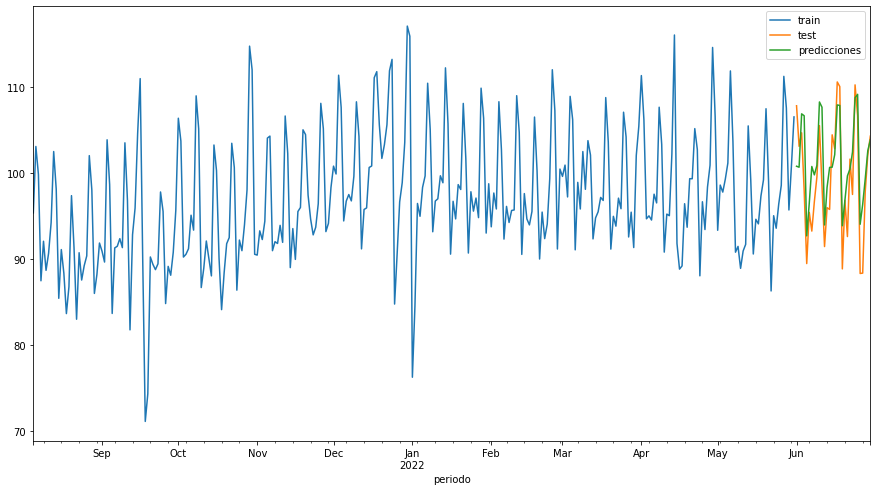

In [217]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(15, 8))
train['y'][-300:].plot(ax=ax, label='train')
test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [218]:
from joblib import dump

# Guardar modelo
dump(forecaster, filename='forecaster.py')

['forecaster.py']

### Validar modelo

In [329]:
demo = read_csv('demo.csv', 'periodo')
demo = time_variables(demo, 'periodo')
demo = data_asfreq(demo, 'total_boletas', 'periodo', 'd')
demo.head(5)

,y,month,dayofweek,dayofmonth,is_holiday
periodo,,,,,
2022-07-01,109.29,7,4,1,0
2022-07-02,103.29,7,5,2,0
2022-07-03,93.70,7,6,3,0
2022-07-04,96.32,7,0,4,0
2022-07-05,97.14,7,1,5,0


Fechas test  : 2022-06-01 00:00:00 --- 2022-06-30 00:00:00  (n=30)
Fechas demo  : 2022-07-01 00:00:00 --- 2022-07-15 00:00:00  (n=15)


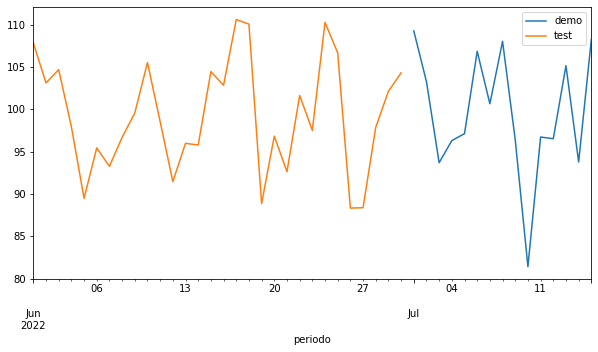

In [220]:
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")
print(f"Fechas demo  : {demo.index.min()} --- {demo.index.max()}  (n={len(demo)})")

fig, ax = plt.subplots(figsize=(10, 5))
demo['y'].plot(ax=ax, label='demo')
test['y'].plot(ax=ax, label='test')
ax.legend();

In [221]:
from joblib import load

model = load('forecaster.py')

In [297]:
tmp_tbl = read_csv('test.csv', 'periodo')

In [294]:
tmp_tbl.head()

,total_boletas
periodo,
2022-06-01,107.864432
2022-06-02,103.138670
2022-06-03,104.716546
2022-06-04,97.958791
2022-06-05,89.490558


In [321]:
def etl_predict(tmp_tbl, steps):
    last_window = tmp_tbl
    last_window_y = last_window['y']
    d_min = last_window.index.min()
    cant_lags = len(last_window)
    periods = cant_lags + steps
    exog_tbl = pd.DataFrame()
    exog_tbl['periodo'] = pd.date_range(start = d_min, periods = periods, freq = 'd')
    exog_tbl = time_variables(exog_tbl, 'periodo')
    exog_tbl = data_asfreq(exog_tbl, None, 'periodo', 'd')
    return last_window_y, exog_tbl

In [335]:
steps = 60
tmp_tbl = read_csv('test.csv', 'periodo')
tmp_tbl = data_asfreq(tmp_tbl, y= 'total_boletas', datetime = 'periodo', freq = 'd')
last_window_y, exog_tbl = etl_predict(tmp_tbl, steps)

In [338]:
predicciones = model.predict(steps=steps, 
                                  last_window= last_window_y,
                                  exog=exog_tbl)

In [348]:
tmp_tbl['is_pred'] = 0
tmp_tbl

,y,is_pred
periodo,,
2022-06-01,107.864432,0
2022-06-02,103.138670,0
2022-06-03,104.716546,0
2022-06-04,97.958791,0
2022-06-05,89.490558,0
2022-06-06,95.453969,0
2022-06-07,93.271313,0
2022-06-08,96.703571,0
2022-06-09,99.576453,0


In [364]:
tmp_tbl = read_csv('test.csv', 'periodo')
tmp_tbl = data_asfreq(tmp_tbl, y= 'total_boletas', datetime = 'periodo', freq = 'd')

tmp_tbl['is_pred'] = 0
tmp_tbl.reset_index(inplace = True)

pred = pd.DataFrame(predicciones)
pred.rename(columns = {'pred': 'y'}, inplace = True)
pred.reset_index(inplace = True)
pred.rename(columns = {'index': 'periodo'}, inplace = True)
pred['is_pred'] = 1

df_timeserie = pd.concat([tmp_tbl, pred])
df_timeserie.sort_values('periodo', inplace = True)
df_timeserie.reset_index(inplace = True, drop = True)
df_timeserie['periodo'] = df_timeserie['periodo'].astype(str)

In [367]:
df_timeserie.T.to_json()

'{"0":{"periodo":"2022-06-01","y":107.8644318953,"is_pred":0},"1":{"periodo":"2022-06-02","y":103.1386700683,"is_pred":0},"2":{"periodo":"2022-06-03","y":104.7165457538,"is_pred":0},"3":{"periodo":"2022-06-04","y":97.9587907581,"is_pred":0},"4":{"periodo":"2022-06-05","y":89.4905583491,"is_pred":0},"5":{"periodo":"2022-06-06","y":95.4539690151,"is_pred":0},"6":{"periodo":"2022-06-07","y":93.2713131375,"is_pred":0},"7":{"periodo":"2022-06-08","y":96.703571139,"is_pred":0},"8":{"periodo":"2022-06-09","y":99.5764526199,"is_pred":0},"9":{"periodo":"2022-06-10","y":105.5528700589,"is_pred":0},"10":{"periodo":"2022-06-11","y":98.5620164375,"is_pred":0},"11":{"periodo":"2022-06-12","y":91.470600163,"is_pred":0},"12":{"periodo":"2022-06-13","y":95.9963682829,"is_pred":0},"13":{"periodo":"2022-06-14","y":95.792686538,"is_pred":0},"14":{"periodo":"2022-06-15","y":104.4795587213,"is_pred":0},"15":{"periodo":"2022-06-16","y":102.8630622158,"is_pred":0},"16":{"periodo":"2022-06-17","y":110.63400657

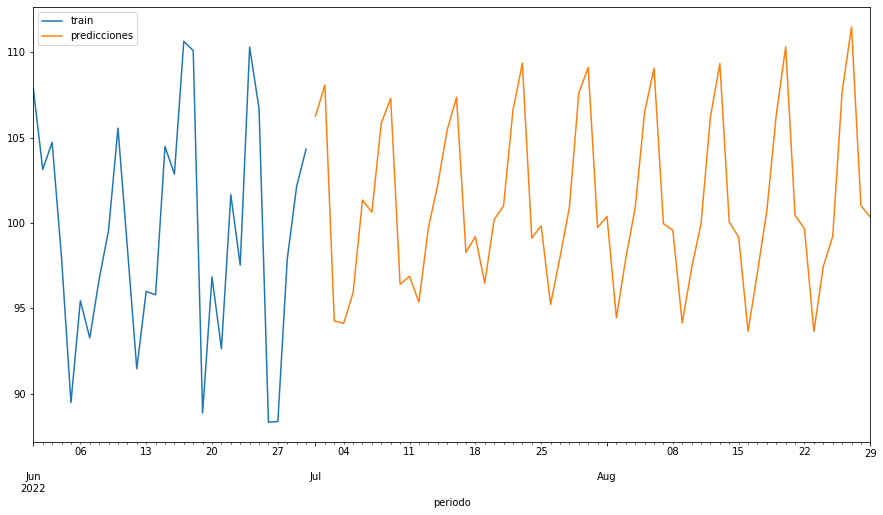

In [339]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(15, 8))
last_window_y.plot(ax=ax, label='train')
#demo['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();